# Clustering

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import random
from functools import partial
import math
from itertools import combinations

In [99]:
Point = complex

def X(point):
    return point.real

def Y(point):
    return point.imag

def distance(A, B):
    return abs(A - B)

def Data(num, seed=42):
    random.seed(seed * num)
    return [Point(random.random(), random.random()) for i in range(num)] 

def FileData(filename):
    with open(filename, "r") as f:
        data = []
        for line in f:
            coord = map(int, line.strip().split())
            data.append(Point(*coord))
        return data

def ClusterData(num_clusters, num_per_cluster, seed=42):
    random.seed(seed * num_clusters * num_per_cluster)
    cluster_centers = [(random.random(), random.random()) for i in range(num_clusters)]
    points = []
    for c in cluster_centers:
        for i in range(num_per_cluster):
            points.append(Point(c[0] + random.random() * 0.2 - 0.1, Point(c[1] + random.random() * 0.2 - 0.1)))
    return points
    

In [4]:
def plot(dataset, s=3, c="k"):
    plt.scatter(map(X, dataset), map(Y, dataset), s=s, c=c)
    plt.axis('off')

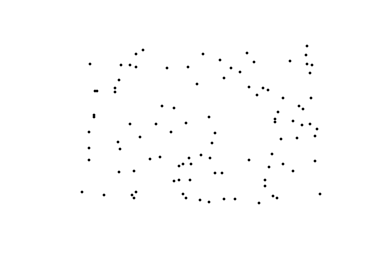

In [33]:
dataset = Data(100)
plot(dataset)

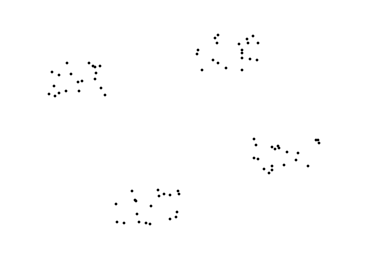

In [110]:
clusterdata = ClusterData(4, 20)
plot(clusterdata)

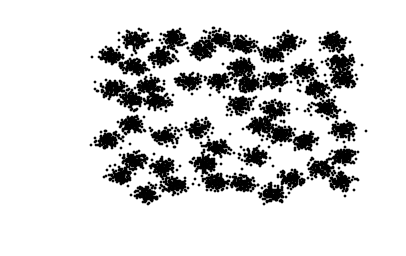

In [6]:
filedata = FileData("data.txt")
plot(filedata)

In [7]:
minX = min(map(X, filedata))
maxX = max(map(X, filedata))
minY = min(map(Y, filedata))
maxY = max(map(Y, filedata))

In [8]:
Sigmoid = complex
avg = lambda x: 0 if len(x) == 0 else sum(x)/len(x)

## K Means

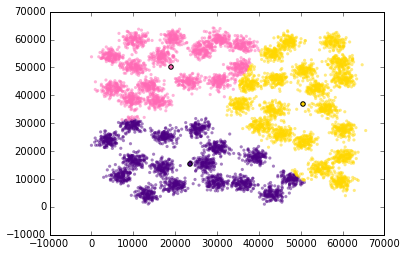

In [9]:
def k_means(data, sigmoids=None, num_clusters=3, iterations=10, seed=42):
    if not sigmoids:
        random.seed(seed * num_clusters)
        sigmoids = {Sigmoid(random.randrange(minX, maxX), random.randrange(minY, maxY)): [] for i in range(num_clusters)}
    for d in data:
        sig = min(((sig, distance(d, sig)) for sig in sigmoids.keys()), key=lambda t: t[1])
        sigmoids[sig[0]].append(d)
    if iterations > 1:
        new_sigmoids = {Sigmoid(X(avg(v)), Y(avg(v))): [] for v in sigmoids.values()}
        return k_means(data, sigmoids=new_sigmoids, num_clusters=num_clusters, iterations=iterations-1)
    return sigmoids

def plot_clusters(clusters):
    cols = iter(matplotlib.colors.cnames)
    for sig, data in clusters.items():
        c = cols.next()
        plt.scatter(map(X, data), map(Y, data), s=10, c=c, alpha=0.5, edgecolor='none')
        plt.scatter([X(sig)], [Y(sig)], s=20, c=c)

plot_clusters(k_means(filedata))

Lets try with initialising more clusters

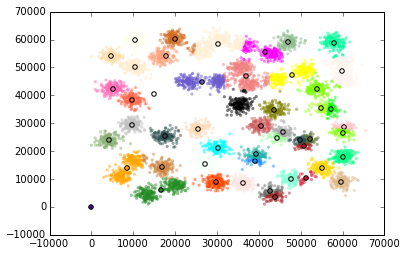

In [10]:
plot_clusters(k_means(filedata, num_clusters=50))

The problem with this us that we don't know how many clusters there are, and the initialization of sigmoids are random. Lets try with some other randomly initialized sigmoids.

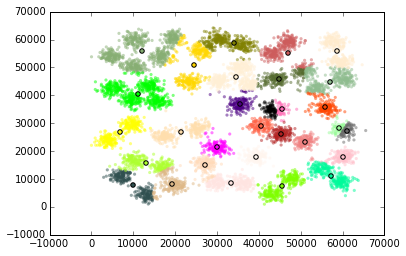

In [11]:
plot_clusters(k_means(filedata, num_clusters=30, seed=1337))

This give a complete different answer, but the number of sigmoids are still way off.

We can iterate different number of clusters, and then pick the best one. For this, we'll need an evaluation function. Lets use *Sum of Squared Errors*.

In [12]:
def SSE(sigmoid, points):
    return sum(distance(sigmoid, p) for p in points)

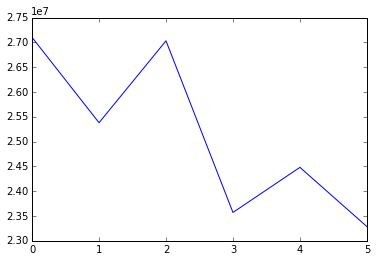

In [13]:
def iter_k_means(min_c=1, max_c=30, seed=8):
    new_seed = seed * max_c * min_c
    results = []
    for i in range(min_c, max_c+1):
        clusters = k_means(filedata, num_clusters=i, seed=new_seed)
        cluster_SSE = [SSE(s, ps) for s, ps in clusters.items()]
        results.append(sum(cluster_SSE))
    return results

def iter_k_means_plot():
    rng = (30, 35)
    result = iter_k_means(*rng)
    plt.plot(result)

iter_k_means_plot()

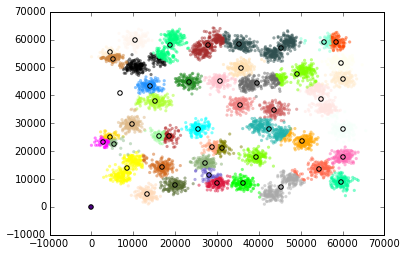

In [14]:
plot_clusters(k_means(filedata, num_clusters=50, seed=20))

## Hierarchical Clustering

We don't need to guess the number of clusters in hierarchical clustering. This is a great advantage.

In [104]:
# class Cluster(list):
    #def __hash__(self):

Cluster = tuple

clusters = []

for d in clusterdata:
    c = Cluster((d,))
    clusters.append(c)
    
cache_min = {}
def min_distance(c1, c2):
    if (c1, c2) in cache_min.keys():
        return cache_min[(c1, c2)]
    tmp_min = None
    for i in c1:
        for j in c2:
            dist = distance(i, j)
            if tmp_min is None or dist < tmp_min:
                tmp_min = dist
    cache_min[(c1, c2)] = tmp_min
    return tmp_min

cache_max = {}
def max_distance(c1, c2):
    if (c1, c2) in cache_max.keys():
        return cache_max[(c1, c2)]
    tmp_min = None
    for i in c1:
        for j in c2:
            dist = distance(i, j)
            if tmp_min is None or dist > tmp_min:
                tmp_min = dist
    cache_max[(c1, c2)] = tmp_min
    return tmp_min

def HAC(clusters, fn_dist=min_distance, repeat=10):
    merge_clusters = (None, None)
    for (c1, c2) in combinations(clusters, 2):
        dist = fn_dist(c1, c2)
        if merge_clusters[0] == None or dist < merge_clusters[1]:
            merge_clusters = ((c1, c2), dist)
    new_cluster = merge_clusters[0][0] + merge_clusters[0][1]
    clusters.remove(merge_clusters[0][0])
    clusters.remove(merge_clusters[0][1])
    clusters.append(new_cluster)
    if repeat > 0:
        return HAC(clusters, fn_dist=fn_dist, repeat=repeat-1)
    print fn_dist
    return clusters

# c1 = (Point(2,3), Point(4,1))
#c2 = (Point(5,3), Point(1,3))
#print max_distance(c1, c2)

<function min_distance at 0x1075bd8c0>


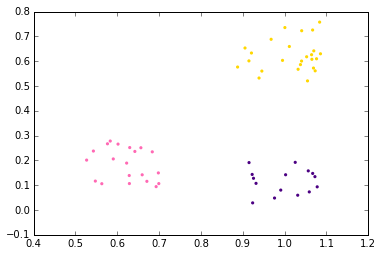

In [113]:
def plot_hac_clusters(clusters):
    cols = iter(matplotlib.colors.cnames)
    for cluster in clusters:
        try:
            c = cols.next()
        except StopIteration:
            cols = iter(matplotlib.colors.cnames)
            c = cols.next()
        plt.scatter(map(X, cluster), map(Y, cluster), s=10, c=c, alpha=1, edgecolor='none')


cl_min = HAC(clusters[:60], fn_dist=min_distance, repeat=56)
plot_hac_clusters(cl_min)

<function max_distance at 0x1078cde60>


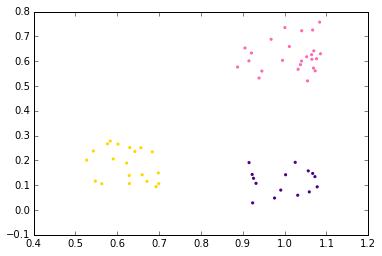

In [114]:
cl_max = HAC(clusters[:60], fn_dist=max_distance, repeat=56)
plot_hac_clusters(cl_max)